<a href="https://colab.research.google.com/github/saidnaqwe/Web-Analytics-Data620/blob/main/Data_620_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data 620 Web Analytics

Project 3 -  Gender Classifier



Said Naqwe

Eddie Xu

Mohamed Hassan-El Serafi



For this project, please work with the entire class as one collaborative group! Your project should be
submitted (as a Jupyter Notebook via GitHub) by end of the due date. The group should present their
code and findings in our meetup.
The ability to be an effective member of a virtual team is highly valued in the data science job market.

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.
Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.
How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect?
Source: Natural Language Processing with Python, exercise 6.10.2.

# Introduction

As a team, we conducted a comprehensive evaluation of machine learning models to compare their performance and identify key strengths and limitations. Our analysis focused on the Decision Tree and Naive Bayes models, assessing their training accuracy, error rates, and predictive consistency across the test set, dev-test set, and an additional dataset. While the Decision Tree model demonstrated higher training accuracy, our collaborative efforts revealed that the Naive Bayes model consistently outperformed it in terms of overall accuracy and reliability in predictions. This joint study lays the groundwork for a detailed discussion of the comparative performance of these models.

# Libraries

In [ ]:
#import libraries
import nltk
import pandas as pd
import random
from nltk.corpus import names
from nltk.classify import apply_features
import collections
import nltk.metrics
from nltk.metrics import precision,recall,f_measure
from nltk import classify
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Data Preparation

Import name data from the NLTK library files for males and females, combine them into a single dataset, and apply random shuffling to the names.

In [ ]:
#import libraries
import nltk
import pandas as pd
import random
from nltk.corpus import names
from nltk.classify import apply_features
import collections
import nltk.metrics
from nltk.metrics import precision,recall,f_measure
import numpy as np
import matplotlib.pyplot as plt
import textwrap as tw

# Download the 'names' dataset from NLTK
nltk.download('names')

#set seed for recreation
random.seed(620)

#get data from NLTK library files
names_list = ([(name, 'male') for name in names.words('male.txt')] +
[(name, 'female') for name in names.words('female.txt')])

# To make sure we are sampling across all the names
# we shuffle them so they aren't alphabetical
random.shuffle(names_list)

#list names
names_list[0:10] # This line will now have access to names_list after running the first cell that defined it

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


[('Christie', 'female'),
 ('Tibold', 'male'),
 ('Chet', 'male'),
 ('Alyss', 'female'),
 ('Eunice', 'female'),
 ('Mehetabel', 'female'),
 ('Marj', 'female'),
 ('Adam', 'male'),
 ('Natka', 'female'),
 ('Sarene', 'female')]

# Data Stats

In [ ]:
print("Total count: " , len(names_list)) # Use names_list instead of names

Total count:  7944


## Dataset Splitting

The dataset is split according to the following criteria:

500 words for the test set
500 words for the dev-test set
The remaining 6,900+ words for the training set

In [ ]:
test_set = names_list[:500] # Use names_list instead of names
print("test set: " , len(test_set))
devtest_set = names_list[500:1000] # Use names_list instead of names
print("dev test set: " , len(devtest_set))
train_set = names_list[1000:] # Use names_list instead of names
print("train set: " , len(train_set))

test set:  500
dev test set:  500
train set:  6944


In [ ]:
male_names = [(name, 'male') for name in names.words('male.txt')]
female_names = [(name, 'female') for name in names.words('female.txt')]
all_names = male_names + female_names

# Shuffle the dataset to ensure it's randomly ordered
random.seed(4657)
random.shuffle(all_names)
ln = len(all_names)
print(f"\nThe first 10 out of {ln} total entries in the shuffled names dataset:\n")
wrapped = tw.fill(str(all_names[:10]))
print(wrapped)


The first 10 out of 7944 total entries in the shuffled names dataset:

[('Iseabal', 'female'), ('Andee', 'female'), ('Englebart', 'male'),
('Susi', 'female'), ('Row', 'female'), ('Delmar', 'male'), ('Faina',
'female'), ('Nero', 'male'), ('Dena', 'female'), ('Crista', 'female')]


In [ ]:
def intersection(lst1, lst2):
    lst3 = [name for (name, _) in lst1 + lst2]
    seen = set()
    overlap = [name for name in lst3 if name in seen or seen.add(name)]
    return overlap
overlap = intersection(male_names, female_names)

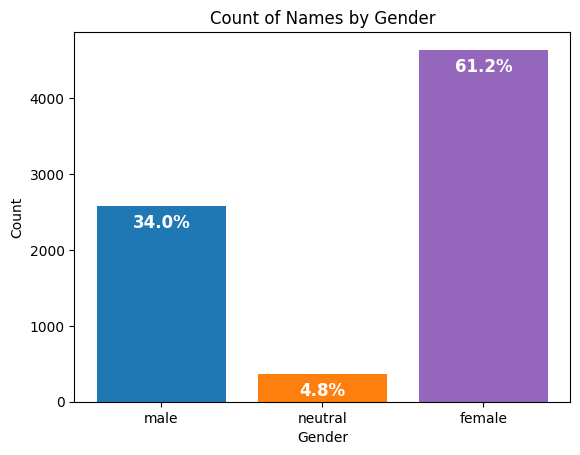

In [ ]:
neutral_names = [(name, "neutral") for name in overlap]
male_names = [(name, gender) for (name, gender) in male_names if name not in overlap]
female_names = [(name, gender) for (name, gender) in female_names if name not in overlap]
all_names = male_names + neutral_names + female_names
x = ["male", "neutral", "female"]
y = [len(male_names), len(neutral_names), len(female_names)]
fig, ax = plt.subplots()
bars = ax.bar(x, y, color = ["tab:blue", "tab:orange", "tab:purple"])
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Count of Names by Gender")
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        perc_str = str(round(100 * height / len(all_names), 1)) + "%"
        ax.text(bar.get_x() + bar.get_width()/2., height - 100,
                '%s' % perc_str, ha = "center", va = "top",
                color = "white", weight = "bold", size = 12)
autolabel(bars)
plt.show()

# Feature Set - Gender

To set up the feature set for predicting the output variable, we focus on individual measurable properties or characteristics of the observed phenomenon. In our case, the features will be various patterns and characteristics of the names.

In [ ]:
def gender_features(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    features["suffix2"]= name[-2:].lower()
    features["preffix2"]= name[:2].lower()
    for letter in 'aeiou':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features

In [ ]:
featuresets = [(gender_features(n), g) for (n,g) in names_list] # Changed 'names' to 'names_list'

In [ ]:
train_set_fe = featuresets[1000:]
test_set_fe =featuresets[:500]
devtest_set_fe =featuresets[500:1000]

# Naive Bayes Classifier

Applying the Naive Bayes Classifier to determine the accuracy of the predictions.

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(train_set_fe)

## Calculate Metrics: Accuracy, Recall, Precision, and F-Measure

In [ ]:
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(train_set_fe):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)

accuracy_train = nltk.classify.accuracy(classifier, train_set_fe)
avg_precision_train = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_train = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_train = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2


refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(test_set_fe):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)

accuracy_test = nltk.classify.accuracy(classifier, test_set_fe)
avg_precision_test = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_test = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_test = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2


for i, (feats, label) in enumerate(devtest_set_fe):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)

accuracy_dev = nltk.classify.accuracy(classifier, devtest_set_fe)
avg_precision_dev = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_dev = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_dev = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2

accuracy_naive_final = [accuracy_train,accuracy_test,accuracy_dev]
precision_naive_final = [avg_precision_train,avg_precision_test,avg_precision_dev]
recall_naive_final = [avg_recall_train,avg_recall_test,avg_recall_dev]
f_measure_naive_final = [avg_f_measure_train,avg_f_measure_test,avg_f_measure_dev]

naive_final_train = [accuracy_train,avg_precision_train,avg_recall_train,avg_f_measure_train]
naive_final_test = [accuracy_test,avg_precision_test,avg_recall_test,avg_f_measure_test]
naive_final_dev = [accuracy_dev,avg_precision_dev,avg_recall_dev,avg_f_measure_dev]
naive_combined = {'Accuracy':accuracy_naive_final,'Precision':precision_naive_final,'Recall':recall_naive_final,'F_Measure':f_measure_naive_final}

df_naive = pd.DataFrame(naive_combined,index=['Train','Test','Dev'],columns=['Accuracy','Precision','Recall','F_Measure'])

## Naive Bayes Features List

In [ ]:
print("---------Naive Bayes Classifier Metrics---------")
print(df_naive)

# Show important features
classifier.show_most_informative_features(20)

---------Naive Bayes Classifier Metrics---------
       Accuracy  Precision    Recall  F_Measure
Train  0.810916   0.437817  0.500000   0.463358
Test   0.802000   0.419760  0.500000   0.454170
Dev    0.778000   0.622769  0.794014   0.695505
Most Informative Features
                 suffix2 = 'na'           female : male   =     93.8 : 1.0
                 suffix2 = 'la'           female : male   =     71.8 : 1.0
                 suffix2 = 'ia'           female : male   =     52.5 : 1.0
              lastletter = 'a'            female : male   =     34.6 : 1.0
                 suffix2 = 'sa'           female : male   =     32.6 : 1.0
                 suffix2 = 'rd'             male : female =     29.4 : 1.0
              lastletter = 'f'              male : female =     28.5 : 1.0
              lastletter = 'k'              male : female =     28.0 : 1.0
                 suffix2 = 'us'             male : female =     27.5 : 1.0
                 suffix2 = 'ra'           female : male   

## Compare with dev test data for error rate - Naive Bayes

In [ ]:
# Check errors
errors = []
for (name, tag) in devtest_set:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

In [ ]:
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=Aurore                        
correct=female   guess=male     name=Austin                        
correct=female   guess=male     name=Barbe                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Bebe                          
correct=female   guess=male     name=Bird                          
correct=female   guess=male     name=Birgit                        
correct=female   guess=male     name=Bunnie                        
correct=female   guess=male     name=Cameo                         
correct=female   guess=male     name=Caron                         
correct=female   guess=male     name=Clemmy                        
correct=female   guess=male     name=Cloris                        
correct=female   guess=male     name=Coleen                        
correct=female   guess=male     name=Colleen                       
correct=female   guess=male     name=Corliss    

## Result of Unmatched Error Count - Naive Bayes

In [ ]:
naive_errors = len(errors)
print("Error count: ", naive_errors)

Error count:  111


# Decision Tree Classifier

Our team applied the decision tree classifier to determine the accuracy of our predictions.

In [ ]:
classifier_tree = nltk.DecisionTreeClassifier.train(train_set_fe)

## Time to Calculate Metrics

In [ ]:
efsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(train_set_fe):
    refsets[label].add(i)
    observed = classifier_tree.classify(feats)
    testsets[observed].add(i)

accuracy_train_dt = nltk.classify.accuracy(classifier_tree, train_set_fe)
avg_precision_train_dt = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_train_dt = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_train_dt = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2


refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(test_set_fe):
    refsets[label].add(i)
    observed = classifier_tree.classify(feats)
    testsets[observed].add(i)

accuracy_test_dt = nltk.classify.accuracy(classifier_tree, test_set_fe)
avg_precision_test_dt = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_test_dt = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_test_dt = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2


for i, (feats, label) in enumerate(devtest_set_fe):
    refsets[label].add(i)
    observed = classifier_tree.classify(feats)
    testsets[observed].add(i)

accuracy_dev_dt = nltk.classify.accuracy(classifier, devtest_set_fe)
avg_precision_dev_dt = (precision(refsets['male'], testsets['male'])+precision(refsets['male'], testsets['female']))/2
avg_recall_dev_dt = (recall(refsets['male'], testsets['male'])+recall(refsets['male'], testsets['female']))/2
avg_f_measure_dev_dt = (f_measure(refsets['male'], testsets['male'])+f_measure(refsets['male'], testsets['female']))/2

accuracy_dt_final = [accuracy_train_dt,accuracy_test_dt,accuracy_dev_dt]
precision_dt_final = [avg_precision_train_dt,avg_precision_test_dt,avg_precision_dev_dt]
recall_dt_final = [avg_recall_train_dt,avg_recall_test_dt,avg_recall_dev_dt]
f_measure_dt_final = [avg_f_measure_train_dt,avg_f_measure_test_dt,avg_f_measure_dev_dt]

dt_final_train = [accuracy_train_dt,avg_precision_train_dt,avg_recall_train_dt,avg_f_measure_train_dt]
dt_final_test = [accuracy_test_dt,avg_precision_test_dt,avg_recall_test_dt,avg_f_measure_test_dt]
dt_final_dev = [accuracy_dev_dt,avg_precision_dev_dt,avg_recall_dev_dt,avg_f_measure_dev_dt]
dt_combined = {'Accuracy':accuracy_dt_final,'Precision':precision_dt_final,'Recall':recall_dt_final,'F_Measure':f_measure_dt_final}
df_dt = pd.DataFrame(dt_combined,index=['Train','Test','Dev'],columns=['Accuracy','Precision','Recall','F_Measure'])

print("---------Decision Tree Classifier Metrics---------")
print(df_dt)

---------Decision Tree Classifier Metrics---------
       Accuracy  Precision   Recall  F_Measure
Train  0.934476   0.519252  0.50000   0.504354
Test   0.748000   0.412386  0.50000   0.448821
Dev    0.778000   0.618290  0.78169   0.686644


## Now Compare with dev test data for error rate - DT

In [ ]:
errors2 = []
for (name, tag) in devtest_set:
    guess = classifier_tree.classify(gender_features(name))
    if guess != tag:
        errors2.append( (tag, guess, name) )

In [ ]:
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=Aurore                        
correct=female   guess=male     name=Austin                        
correct=female   guess=male     name=Barbe                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Bebe                          
correct=female   guess=male     name=Bird                          
correct=female   guess=male     name=Birgit                        
correct=female   guess=male     name=Bunnie                        
correct=female   guess=male     name=Cameo                         
correct=female   guess=male     name=Caron                         
correct=female   guess=male     name=Clemmy                        
correct=female   guess=male     name=Cloris                        
correct=female   guess=male     name=Coleen                        
correct=female   guess=male     name=Colleen                       
correct=female   guess=male     name=Corliss    

## Result of Unmatched Error Count - DT

In [ ]:
dt_errors = len(errors2)
print("Error count: ", dt_errors)

Error count:  135


## Classifier Comparison Charts

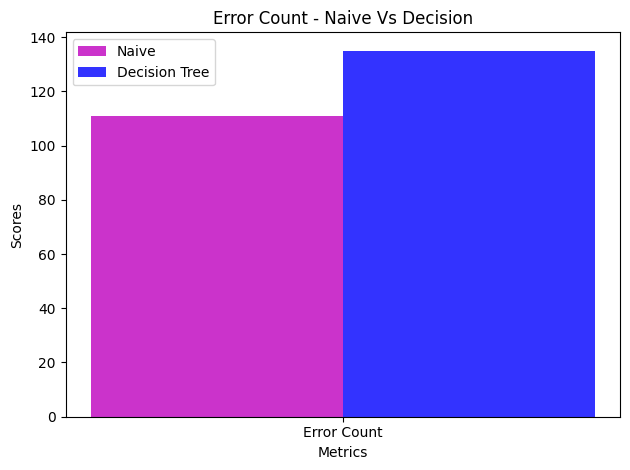

In [ ]:
n_groups = 1
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.05
opacity = 0.8

rects1 = plt.bar(index, naive_errors, bar_width,
alpha=opacity,
color='m',
label='Naive')

rects2 = plt.bar(index + bar_width, dt_errors, bar_width,
alpha=opacity,
color='b',
label='Decision Tree')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Error Count - Naive Vs Decision')
# The following line is changed.
# Previously: plt.xticks(index + bar_width, ('Error Count'))
# This resulted in an error as ('Error Count') was interpreted as 11 labels.
# We want a single label, so we encapsulate 'Error Count' in a list: ['Error Count'].
plt.xticks(index + bar_width/2, ['Error Count']) # Put 'Error Count' in a list
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report

## Naive Bayes

### Confusion Matrix Train Set

In [ ]:
# Get true labels and predicted labels
true_labels_train = [label for (_, label) in train_set]
predicted_labels_train = [classifier.classify(gender_features(name)) for (name, _) in train_set]

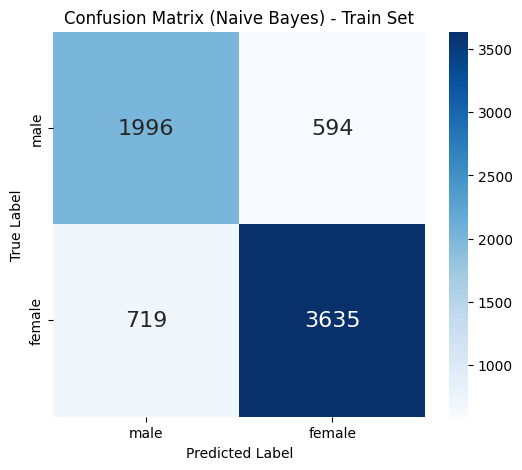

In [ ]:
# Create confusion matrix
cm_train_nb = confusion_matrix(true_labels_train, predicted_labels_train, labels=["male", "female"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_train_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Naive Bayes) - Train Set")
plt.show()

### Confusion Matrix Test Set

In [ ]:
# Get true labels and predicted labels
true_labels_test = [label for (_, label) in test_set]
predicted_labels_test = [classifier.classify(gender_features(name)) for (name, _) in test_set]


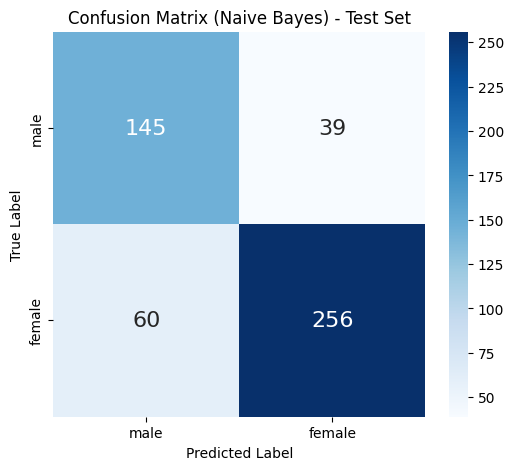

In [ ]:
# Create confusion matrix
cm_test_nb = confusion_matrix(true_labels_test, predicted_labels_test, labels=["male", "female"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Naive Bayes) - Test Set")
plt.show()


### Confusion Matrix Dev Test

In [ ]:
# Get true labels and predicted labels
true_labels_test_dev = [label for (_, label) in devtest_set]
predicted_labels_test_dev = [classifier.classify(gender_features(name)) for (name, _) in devtest_set]

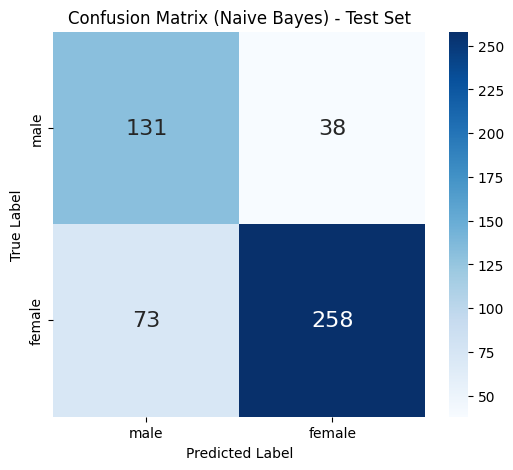

In [ ]:
# Create confusion matrix
cm_dev_nb = confusion_matrix(true_labels_test_dev, predicted_labels_test_dev, labels=["male", "female"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_dev_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Naive Bayes) - Test Set")
plt.show()

### Classification Report

In [ ]:
# Get predictions for train and test
train_y_true = [gender for (_, gender) in train_set]
train_y_pred = [classifier.classify(gender_features(name)) for (name, _) in train_set]

test_y_true = [gender for (_, gender) in test_set]
test_y_pred = [classifier.classify(gender_features(name)) for (name, _) in test_set]

# Confusion Matrix
print("Train Confusion Matrix:")
print(confusion_matrix(train_y_true, train_y_pred))
print("\nTest Confusion Matrix:")
print(confusion_matrix(test_y_true, test_y_pred))

# Classification Report
print("\nTrain Classification Report:")
print(classification_report(train_y_true, train_y_pred))

print("\nTest Classification Report:")
print(classification_report(test_y_true, test_y_pred))


Train Confusion Matrix:
[[3635  719]
 [ 594 1996]]

Test Confusion Matrix:
[[256  60]
 [ 39 145]]

Train Classification Report:
              precision    recall  f1-score   support

      female       0.86      0.83      0.85      4354
        male       0.74      0.77      0.75      2590

    accuracy                           0.81      6944
   macro avg       0.80      0.80      0.80      6944
weighted avg       0.81      0.81      0.81      6944


Test Classification Report:
              precision    recall  f1-score   support

      female       0.87      0.81      0.84       316
        male       0.71      0.79      0.75       184

    accuracy                           0.80       500
   macro avg       0.79      0.80      0.79       500
weighted avg       0.81      0.80      0.80       500



In [ ]:
# Evaluate on train
train_accuracy = classify.accuracy(classifier, train_set_fe )
print(f"Train Accuracy: {train_accuracy:.2%}")


# Evaluate on test
test_accuracy = classify.accuracy(classifier, test_set_fe)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Evaluate on devtest
devtest_accuracy = classify.accuracy(classifier, devtest_set_fe )
print(f"Dev-test Accuracy: {devtest_accuracy:.2%}")

Train Accuracy: 81.09%
Test Accuracy: 80.20%
Dev-test Accuracy: 77.80%


## Decision Tree

### Confusion Matrix Train Set

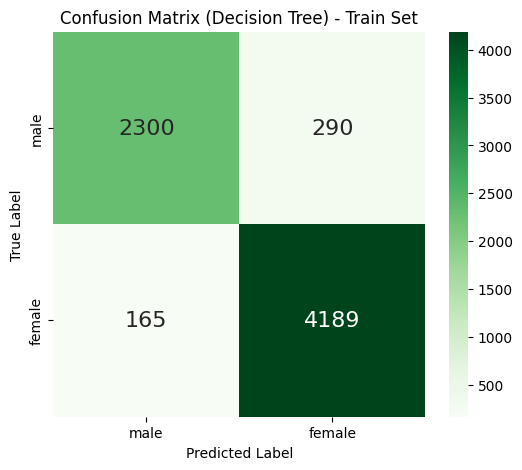

In [ ]:
# Get true labels and predicted labels
true_tree_labels_train = [label for (_, label) in train_set]
predicted_tree_labels_train = [classifier_tree.classify(gender_features(name)) for (name, _) in train_set]

# Create confusion matrix
cm_tree_train = confusion_matrix(true_tree_labels_train, predicted_tree_labels_train, labels=["male", "female"])

# Plot the confusion matrix for decision tree (train)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tree_train, annot=True, fmt="d", cmap="Greens", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Decision Tree) - Train Set")
plt.show()


### Confusion Matrix Test Set

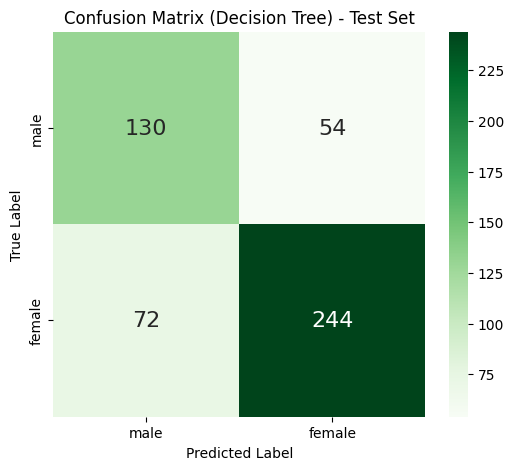

In [ ]:
# Get true labels and predicted labels
true_tree_labels_test = [label for (_, label) in test_set]
predicted_tree_labels_test = [classifier_tree.classify(gender_features(name)) for (name, _) in test_set]

# Create confusion matrix
cm_tree_test = confusion_matrix(true_tree_labels_test, predicted_tree_labels_test, labels=["male", "female"])

# Plot the confusion matrix for decision tree (test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tree_test, annot=True, fmt="d", cmap="Greens", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Decision Tree) - Test Set")
plt.show()

### Confusion Matrix Dev Test

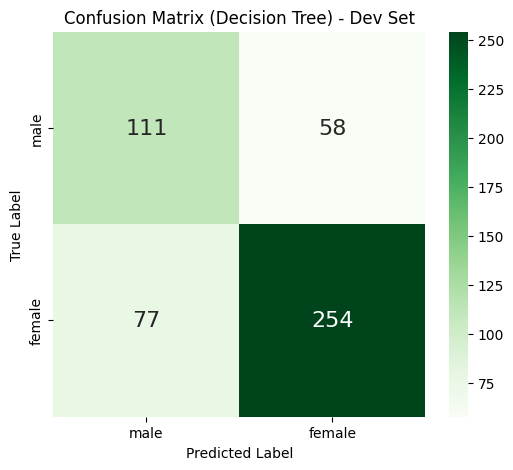

In [ ]:
# Get true labels and predicted labels
true_tree_labels_devtrain = [label for (_, label) in devtest_set]
predicted_tree_labels_devtrain = [classifier_tree.classify(gender_features(name)) for (name, _) in devtest_set]

# Create confusion matrix
cm_tree_train_dev = confusion_matrix(true_tree_labels_devtrain, predicted_tree_labels_devtrain, labels=["male", "female"])

# Plot the confusion matrix for decision tree (train)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tree_train_dev, annot=True, fmt="d", cmap="Greens", xticklabels=["male", "female"], yticklabels=["male", "female"], annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Decision Tree) - Dev Set")
plt.show()

### Classification Report

In [ ]:
# Get predictions for train and test
train_y_true_tree = [gender for (_, gender) in train_set]
train_y_pred_tree = [classifier_tree.classify(gender_features(name)) for (name, _) in train_set]

test_y_true_tree = [gender for (_, gender) in test_set]
test_y_pred_tree = [classifier_tree.classify(gender_features(name)) for (name, _) in test_set]

# Confusion Matrix
print("Train Confusion Matrix:")
print(confusion_matrix(train_y_true_tree, train_y_pred_tree))
print("\nTest Confusion Matrix:")
print(confusion_matrix(test_y_true_tree, test_y_pred_tree))

# Classification Report
print("\nTrain Classification Report:")
print(classification_report(train_y_true_tree, train_y_pred_tree))

print("\nTest Classification Report:")
print(classification_report(test_y_true_tree, test_y_pred_tree))

# Evaluate on train
train_accuracy = classify.accuracy(classifier_tree, train_set_fe )
print(f"Train Accuracy: {train_accuracy:.2%}")


# Evaluate on test
test_accuracy = classify.accuracy(classifier_tree, test_set_fe)
print(f"Test Accuracy: {test_accuracy:.2%}")

# Evaluate on devtest
devtest_accuracy = classify.accuracy(classifier_tree, devtest_set_fe )
print(f"Dev-test Accuracy: {devtest_accuracy:.2%}")

Train Confusion Matrix:
[[4189  165]
 [ 290 2300]]

Test Confusion Matrix:
[[244  72]
 [ 54 130]]

Train Classification Report:
              precision    recall  f1-score   support

      female       0.94      0.96      0.95      4354
        male       0.93      0.89      0.91      2590

    accuracy                           0.93      6944
   macro avg       0.93      0.93      0.93      6944
weighted avg       0.93      0.93      0.93      6944


Test Classification Report:
              precision    recall  f1-score   support

      female       0.82      0.77      0.79       316
        male       0.64      0.71      0.67       184

    accuracy                           0.75       500
   macro avg       0.73      0.74      0.73       500
weighted avg       0.75      0.75      0.75       500

Train Accuracy: 93.45%
Test Accuracy: 74.80%
Dev-test Accuracy: 73.00%


# Analysis:
Naive Bayes and Decision Tree classifers provide different results. The Decision Tree classifier had a train accuracy of 93.45%, higher than Naive Bayes' train accuracy of 81.09%. However, Naive Bayes had higher test and dev-test accuracy results than Decision Tree, with 80.20% and 77.80%, respectively, compared to the results of Decision Tree which had a test set accuracy of 73.80% and dev-set accuracy of 73.20%. For both classifiers, the test sets of female names had higher f1-scores than male names, with the test set in Naive Bayes achieving a higher percentage in both female and male names than Decision Tree.

# Conclusion:
The comparison of performance between the test set and the dev-test set yields notable findings. While the Decision Tree model achieved higher training accuracy compared to the Naive Bayes model, it also resulted in a significantly greater number of unmatched errors. On the other hand, when considering the average accuracy across the three datasets and the consistency of matched predictions, the Naive Bayes model demonstrated superior performance overall, outperforming the Decision Tree model.
